In [1]:
import os
import sys
import pathlib
import yaml
import subprocess
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import umap.umap_ as umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from matplotlib_venn import venn2, venn3
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
import tensorflow as tf
from tensorflow.keras.utils import plot_model

2025-03-25 17:13:26.528014: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 17:13:26.536886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742944406.546037  621216 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742944406.548796  621216 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742944406.556800  621216 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Metadata Column Definition

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'

GENE_ID_COL = 'gene_ids'

DATASPLIT_COL = 'isTraining'

## Define paths to Required Input Files
### Load config
The config file specifies the path to data and software repo (due to currently in active development)

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

### Import in development buddi

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_HGSC']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.insert(0, str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from buddi.models.buddi4 import build_buddi4, fit_buddi4_v2
# from prototype_buddi_dataset import *
from buddi.dataset.dataset import get_dataset
from buddi.dataset.utils import train_validation_split
from buddi.plotting.plot_latent_space import plot_latent_spaces_buddi4

2025-03-25 17:13:27.407190: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-25 17:13:27.407205: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-03-25 17:13:27.407209: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-03-25 17:13:27.407213: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-03-25 17:13:27.407215: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: pop-os
2025-03-25 17:13:27.407217: I external/local_xla/xla/stream_executor/cuda/cuda_d

### Pre-Processing Output presence

In [5]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data'
assert PREPROCESSING_OUTPUT_PATH.exists(), f"Preprocessing output path {PREPROCESSING_OUTPUT_PATH} does not exist"

SC_AUGMENTED_DATA_PATH = PREPROCESSING_OUTPUT_PATH / 'sc_augmented'
assert SC_AUGMENTED_DATA_PATH.exists(), f"Single cell augmented data path {SC_AUGMENTED_DATA_PATH} does not exist"
pseudobulk_files = list(SC_AUGMENTED_DATA_PATH.glob('*_splits.pkl'))
assert len(pseudobulk_files) > 0, f"No pseudobulk files found in {SC_AUGMENTED_DATA_PATH}"

BULK_FORMAT_DATA_PATH = PREPROCESSING_OUTPUT_PATH / 'bulk_formatted'
assert BULK_FORMAT_DATA_PATH.exists(), f"Bulk format data path {BULK_FORMAT_DATA_PATH} does not exist"
formatted_bulk_files = list(BULK_FORMAT_DATA_PATH.glob('*.h5ad'))
assert len(formatted_bulk_files) > 0, f"No formatted bulk files found in {BULK_FORMAT_DATA_PATH}"

### Cibersortx signature gene file 

In [6]:
## (TODO this is really ugly, maybe the data path should have a dedicated path to cibersortx output)?
CIBERSORTX_SIG_GENE_FILE = pathlib.Path(config_dict['data_path']['sc_data_path']) /\
    'GSE154600_cibersortx_output' /\
    'CIBERSORTx_Job4_GSM4675273_cibersortx_sc_reference_input_inferred_phenoclasses.CIBERSORTx_Job4_GSM4675273_cibersortx_sc_reference_input_inferred_refsample.bm.K999.txt'
assert CIBERSORTX_SIG_GENE_FILE.exists(), f"CIBERSORTx signature gene file not found at {CIBERSORTX_SIG_GENE_FILE}"

cibersortx_sig_df = pd.read_csv(CIBERSORTX_SIG_GENE_FILE, sep='\t', header=0)
cibersortx_sig_genes = cibersortx_sig_df['NAME'].values.tolist()
print(f"{len(cibersortx_sig_genes)} signature genes from CIBERSORTx")

2892 signature genes from CIBERSORTx


### Gene id metadata files for both sc pseudobulk and real bulk

Number of bulk genes: 18509
Number of single cell genes: 24520
Number of genes in intersection of single cell and bulk: 15836


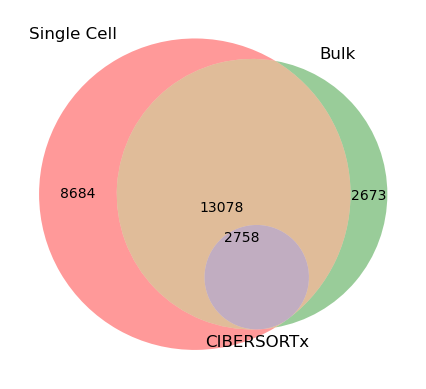

In [7]:
bulk_gene_file = BULK_FORMAT_DATA_PATH.glob('*.pkl')
bulk_gene_file = list(bulk_gene_file)[0]
bulk_genes = pd.read_pickle(bulk_gene_file)
print(f"Number of bulk genes: {len(bulk_genes)}")

sc_gene_file = SC_AUGMENTED_DATA_PATH.glob('*_genes.pkl')
sc_gene_file = list(sc_gene_file)[0]
sc_genes = pd.read_pickle(sc_gene_file)
print(f"Number of single cell genes: {len(sc_genes)}")

# Intersect the genes
sc_bulk_intersection_genes = set(sc_genes) & set(bulk_genes)
sc_bulk_intersection_genes = list(sc_bulk_intersection_genes)
print(f"Number of genes in intersection of single cell and bulk: {len(sc_bulk_intersection_genes)}")

# drop cibersortx signature genes that are not in the sc bulk intersection
cibersortx_sig_genes = set(cibersortx_sig_genes).intersection(sc_bulk_intersection_genes)
cibersortx_sig_genes = list(cibersortx_sig_genes)

# Visualize the raw overlap of genes
venn3(
    [
        set(sc_genes),
        set(bulk_genes),
        set(cibersortx_sig_genes)
    ],
    set_labels=['Single Cell', 'Bulk', 'CIBERSORTx']
)


### Load Processed Bulk

In [8]:
processed_bulk = sc.read(formatted_bulk_files[0]) 

bulk_sample_ids = processed_bulk.obs[SAMPLE_ID_COL].unique()
n_bulk_samples = len(bulk_sample_ids)
print(f"Number of bulk samples: {n_bulk_samples}")

bulk_stims = processed_bulk.obs[STIM_COL].unique()
n_bulk_stims = len(bulk_stims)
print(f"Number of bulk stims: {n_bulk_stims}")

## Subset the bulk data to only include the intersection genes
processed_bulk = processed_bulk[
    :, 
    processed_bulk.var[GENE_ID_COL].isin(sc_bulk_intersection_genes)]

X_bulk_train = pd.DataFrame(
    processed_bulk.X,
    index=processed_bulk.obs[SAMPLE_ID_COL],
    columns=processed_bulk.var[GENE_ID_COL]
)

# Add metadata columns 
## TODO: perhaps move this to preprocessing?
meta_bulk_train = processed_bulk.obs.loc[:,[SAMPLE_ID_COL, STIM_COL]]
meta_bulk_train['isTraining'] = 'Train'
meta_bulk_train['cell_prop_type'] = 'bulk'
meta_bulk_train['samp_type'] = 'bulk'

Number of bulk samples: 588
Number of bulk stims: 2


### Load sc Pseudobulk

In [9]:
pattern = re.compile(r'^(.*)_((?:Train)|(?:Test))_((?:meta)|(?:prop)|(?:pseudo))_splits\.pkl$')

# Temporary dictionary to group by sample_id
temp_dict = defaultdict(lambda: defaultdict(dict))

for path in pseudobulk_files:
    file = path.name
    match = pattern.match(file)
    if match:
        sample_id, datasplit, datatype = match.groups()
        temp_dict[datasplit][sample_id][datatype] = path

# Organizing the sorted results
grouped_files = {
    "Train": {"meta": [], "prop": [], "pseudo": []},
    "Test": {"meta": [], "prop": [], "pseudo": []}
}

# Sort within each datasplit by sample_id and organize the lists
for datasplit in ["Train", "Test"]:
    sorted_samples = sorted(temp_dict[datasplit].keys())  # Sort by sample_id
    for sample_id in sorted_samples:
        for datatype in ["meta", "prop", "pseudo"]:
            if datatype in temp_dict[datasplit][sample_id]:
                grouped_files[datasplit][datatype].append(temp_dict[datasplit][sample_id][datatype])

meta_sc_train = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Train']['meta']]
)
meta_sc_train[STIM_COL] = 'white' # assume all single cell samples are from white individuals
Y_sc_train = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Train']['prop']]
)
X_sc_train = pd.concat(
    [pd.read_pickle(file).loc[:, sc_bulk_intersection_genes] for file in grouped_files['Train']['pseudo']]
)

### Concatenate X, Y, Gene Feature Selection,  and Encode Metadata

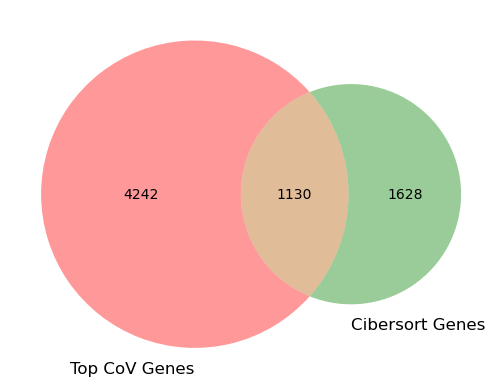

(21588, 7000)


In [10]:
# Generate place holder for bulk proportion (not used)
Y_bulk_dummy = pd.DataFrame(
    np.zeros((X_bulk_train.shape[0], Y_sc_train.shape[1])),
    columns=Y_sc_train.columns
)

X_concat = pd.concat([X_bulk_train, X_sc_train])
Y_concat = pd.concat([Y_bulk_dummy, Y_sc_train])
meta_concat = pd.concat([meta_bulk_train, meta_sc_train])

# save gene and cell type names
X_gene_names = X_concat.columns.to_list()
Y_cell_type_names = Y_concat.columns.to_list()

## get the top variable genes
X_colmean = X_concat.values.mean(axis=0) # mean across samples
X_colvar = X_concat.values.var(axis=0) # variance across samples
# coefficient of variation which is the var to mean ratio
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001)) 

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False

gene_df = pd.DataFrame(X_gene_names, columns=['gene'])

# start with top 7000 genes by CoV
initial_count = 7000
while not num_genes_found:
    # retrieve the top initial_count genes by CoV
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    # get gene names from idx_top
    top_gene_df = gene_df.iloc[idx_top]

    # produce the union of the top genes and the cibersort genes
    CoV_only = np.union1d(top_gene_df, cibersortx_sig_genes)

    # check if the union is 7000
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        # if not decrement the top CoV gene to retrieve by 1
        # in the next iteration, there will be two possibilities
        # 1. the union will have one less gene due to the removed gene being only in the CoV genes
        # 2. the union will have the same number of genes as this iteration due to the removed 
        #    gene being also present in CIBERSORTx genes
        # keep running this loop until the union has 7000 genes
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]
venn2([set(gene_df.values.flatten()), 
       set(cibersortx_sig_genes)], 
       set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

feature_select_genes = np.union1d(gene_df, cibersortx_sig_genes)

# to numpy matrix
X = X_concat.loc[:,feature_select_genes].to_numpy()
print(X.shape)

Y = Y_concat.to_numpy()

FIELDS_TO_ENCODE = [SAMPLE_ID_COL, STIM_COL, TECH_COL]

encoded = {}

for field in FIELDS_TO_ENCODE:
    encoder = OneHotEncoder(dtype=int)
    encoded[field] = pd.DataFrame(
        encoder.fit_transform(meta_concat.loc[:,[field]]).toarray(),
        columns=encoder.get_feature_names_out([field])
    )

### Normalization

In [11]:
## normalize within sample
clip_upper = np.quantile(X, 0.9)
X_full = np.clip(X, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)

### Supervised vs Unsupervised split

In [12]:
idx_train = np.where(meta_concat.isTraining=="Train")[0] 
idx_bulk = np.where(meta_concat.samp_type == "bulk")[0]
idx_sc = np.where(meta_concat.samp_type != "bulk")[0]

# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train)
np.random.shuffle(idx_bulk_train) # shuffle the indices randomly

X_unkp = X_full[idx_bulk_train,]
label_unkp = encoded[SAMPLE_ID_COL].values[idx_bulk_train,]
drug_unkp = encoded[STIM_COL].values[idx_bulk_train,]
bulk_unkp = encoded[TECH_COL].values[idx_bulk_train,]
y_unkp = Y[idx_bulk_train,]

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train)
np.random.shuffle(idx_sc_train) # shuffle the indices randomly

X_kp = X_full[idx_sc_train,]
label_kp = encoded[SAMPLE_ID_COL].values[idx_sc_train,]
drug_kp = encoded[STIM_COL].values[idx_sc_train,]
bulk_kp = encoded[TECH_COL].values[idx_sc_train,]
y_kp = Y[idx_sc_train,]

## Training

In [13]:
n_x = X_full.shape[1]
n_y = Y.shape[1]
n_labels = encoded[SAMPLE_ID_COL].shape[1]
n_stims = encoded[STIM_COL].shape[1]
n_samp_types = encoded[TECH_COL].shape[1]

### Dataset

In [14]:
ds_sup = get_dataset(
    input_tuple_order = ['X', 'Y_prop'],
    output_tuple_order = ['X', 'z_label', 'z_stim', 'z_samp_type', 'z_slack', 'label', 'stim', 'samp_type', 'Y_prop'],
    X = X_kp,
    Y_prop = y_kp,
    label = label_kp,
    stim = drug_kp,
    samp_type = bulk_kp,
)
print(ds_sup.cardinality().numpy())

ds_unsup = get_dataset(
    input_tuple_order = ['X'],
    output_tuple_order = ['X', 'z_label', 'z_stim', 'z_samp_type', 'z_slack', 'label', 'stim', 'samp_type', 'Y_dummy'],
    X = X_unkp,
    label = label_unkp,
    stim = drug_unkp,
    samp_type = bulk_unkp,
)
print(ds_unsup.cardinality().numpy())

10500
588


### Instantiate BuDDI 4 model

In [15]:
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

supervised_buddi, unsupervised_buddi = build_buddi4(
    n_x=n_x,
    n_y=n_y,
    n_labels=n_labels,
    n_stims=n_stims,
    n_samp_types=n_samp_types,
    reconstr_loss_fn = MeanSquaredError, # default reconstruction loss is mean squared error
    classifier_loss_fn = CategoricalCrossentropy, # default classifier loss is categorical crossentropy
    # Default loss weights
    alpha_label = 100.0,
    alpha_stim = 100.0,
    alpha_samp_type = 100.0,
    alpha_prop = 100.0,
    beta_kl_slack = 0.1,
    beta_kl_label = 100.0,
    beta_kl_stim = 100.0,
    beta_kl_samp_type = 100.0,
)

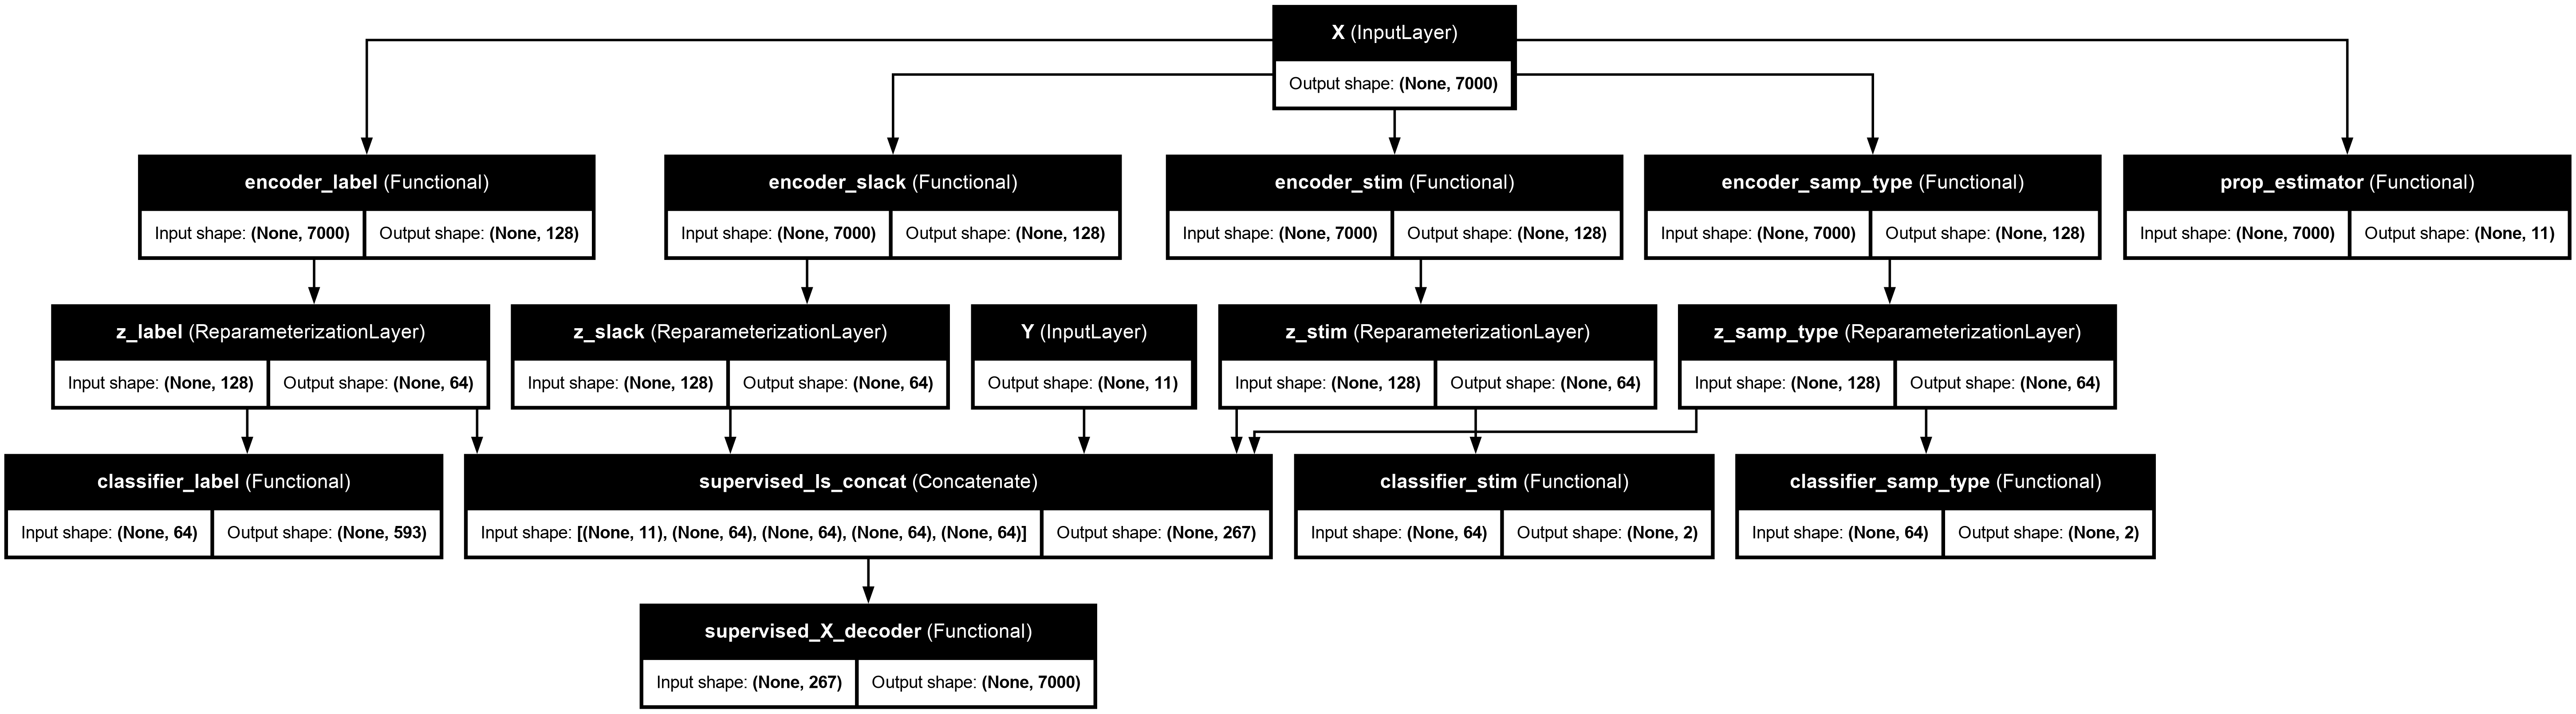

In [16]:
plot_model(
    supervised_buddi, 
    to_file='supervised_buddi.png', 
    show_shapes=True, 
    show_layer_names=True)

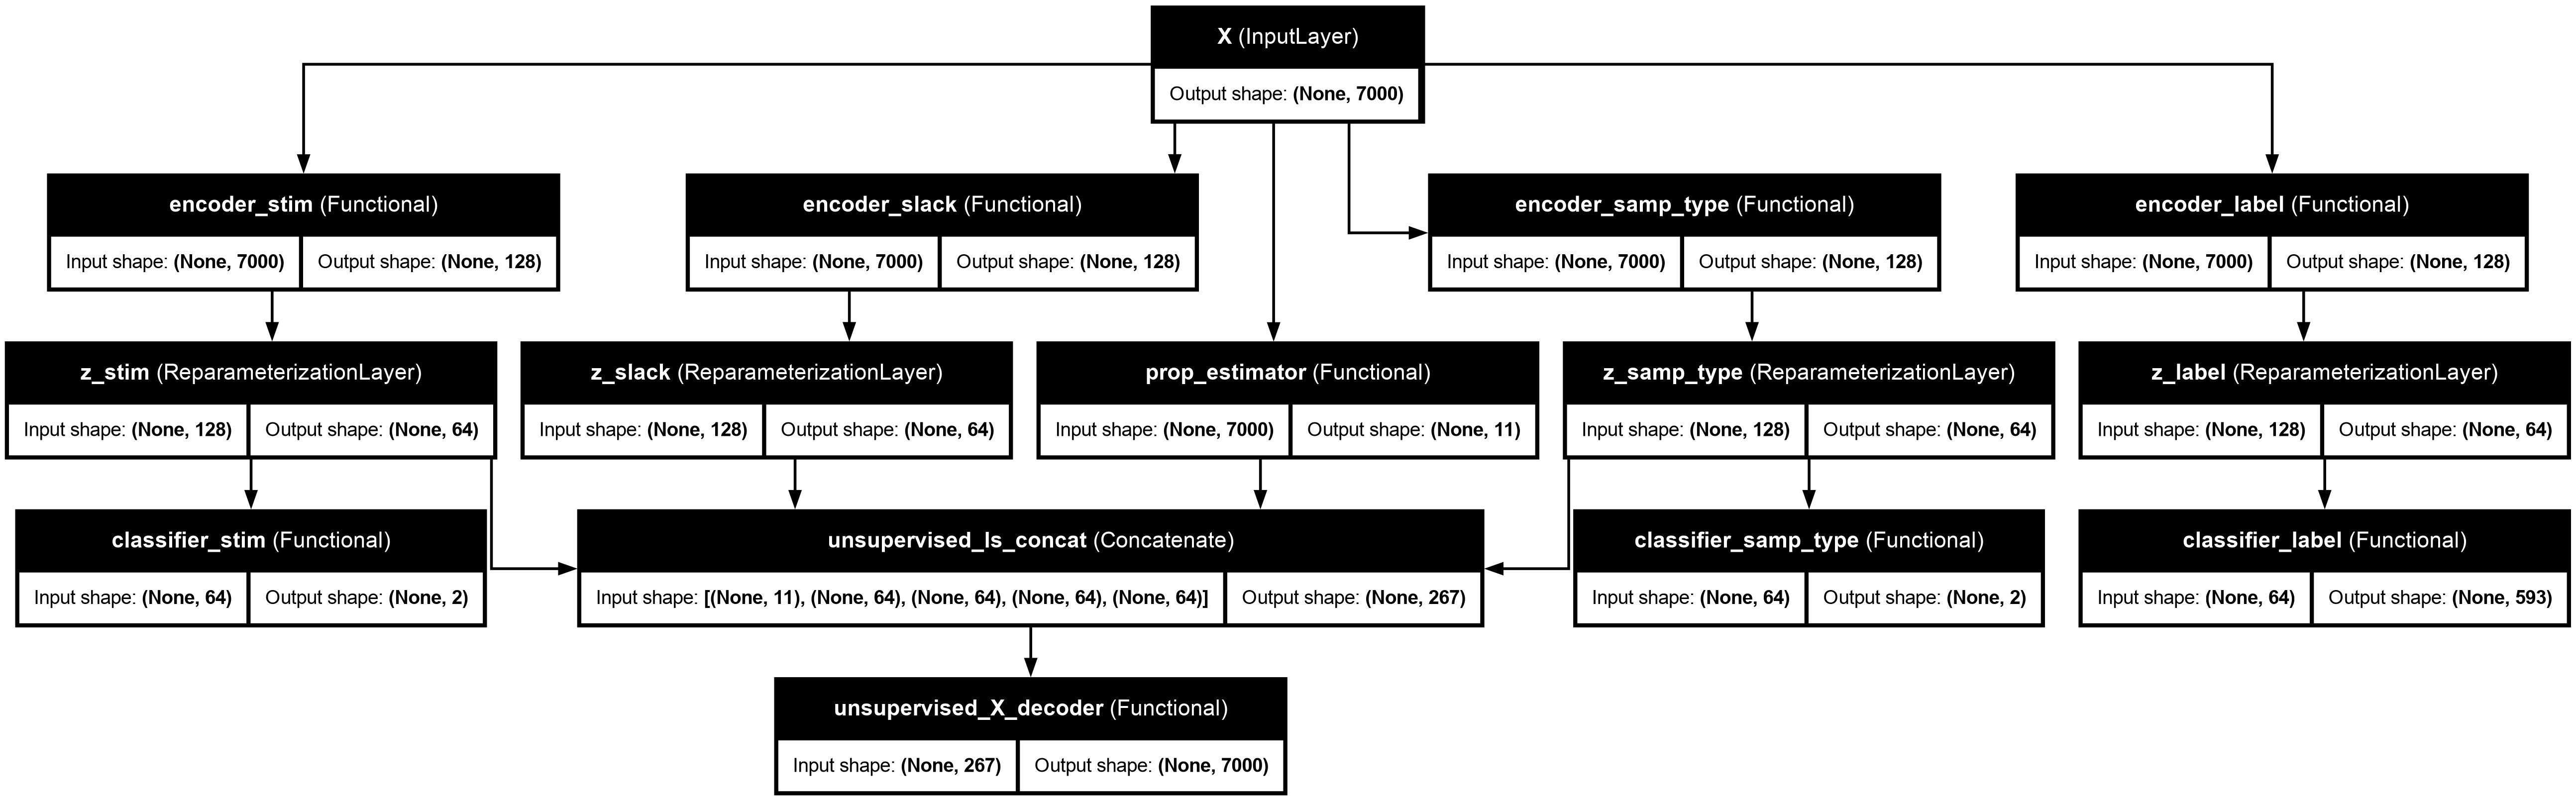

In [17]:
plot_model(
    unsupervised_buddi, 
    to_file='unsupervised_buddi.png', 
    show_shapes=True, 
    show_layer_names=True)

In [18]:
!rm supervised_buddi.png
!rm unsupervised_buddi.png

### Visualization Data and Helper Function

In [19]:
# get the training pseudobulks
idx_tmp_bulk = np.where(np.logical_and(meta_concat.isTraining == "Train", meta_concat.samp_type == "sc_ref"))[0]
idx_tmp_bulk = np.random.choice(idx_tmp_bulk, 500, replace=True)

# get the real bulks
idx_tmp = np.where(np.logical_and(meta_concat.isTraining == "Train", meta_concat.samp_type == "bulk"))[0]
idx_tmp = np.random.choice(idx_tmp, 500, replace=True)

# concatenate so we have them all
idx_tmp = np.concatenate((idx_tmp, idx_tmp_bulk))

X_tmp = X_full[idx_tmp,]
meta_tmp = meta_concat.iloc[idx_tmp,]

cell_types = list(Y_concat.columns)
Y_tmp = Y[idx_tmp,]
idx_sc_prop = np.where(meta_tmp.cell_prop_type == "single_celltype")[0]
cell_type_labels = [cell_types[i] for i in np.argmax(Y_tmp[idx_sc_prop, :], axis=1)]
cell_type_col = meta_tmp.loc[:,'cell_prop_type'].values.copy()
cell_type_col[idx_sc_prop] = cell_type_labels
meta_tmp.loc[:,'cell_type'] = cell_type_col

def simple_plot_loss(loss_df):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)

    loss_columns = [
        'X_reconstruction_loss', 
        'classifier_label_loss', 
        'classifier_stim_loss', 
        'classifier_samp_type_loss', 
        'prop_estimator_loss'
    ]

    for ax, col in zip(axes, loss_columns):
        sns.lineplot(
            data=loss_df, 
            x='index', 
            y=col, 
            hue='type', 
            ax=ax
        )
        ax.set_title(col)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

    plt.tight_layout()
    plt.show()

### Train Loop

Epoch 2/2: 100%|██████████| 165/165 [00:56<00:00,  2.94it/s]


Training complete!


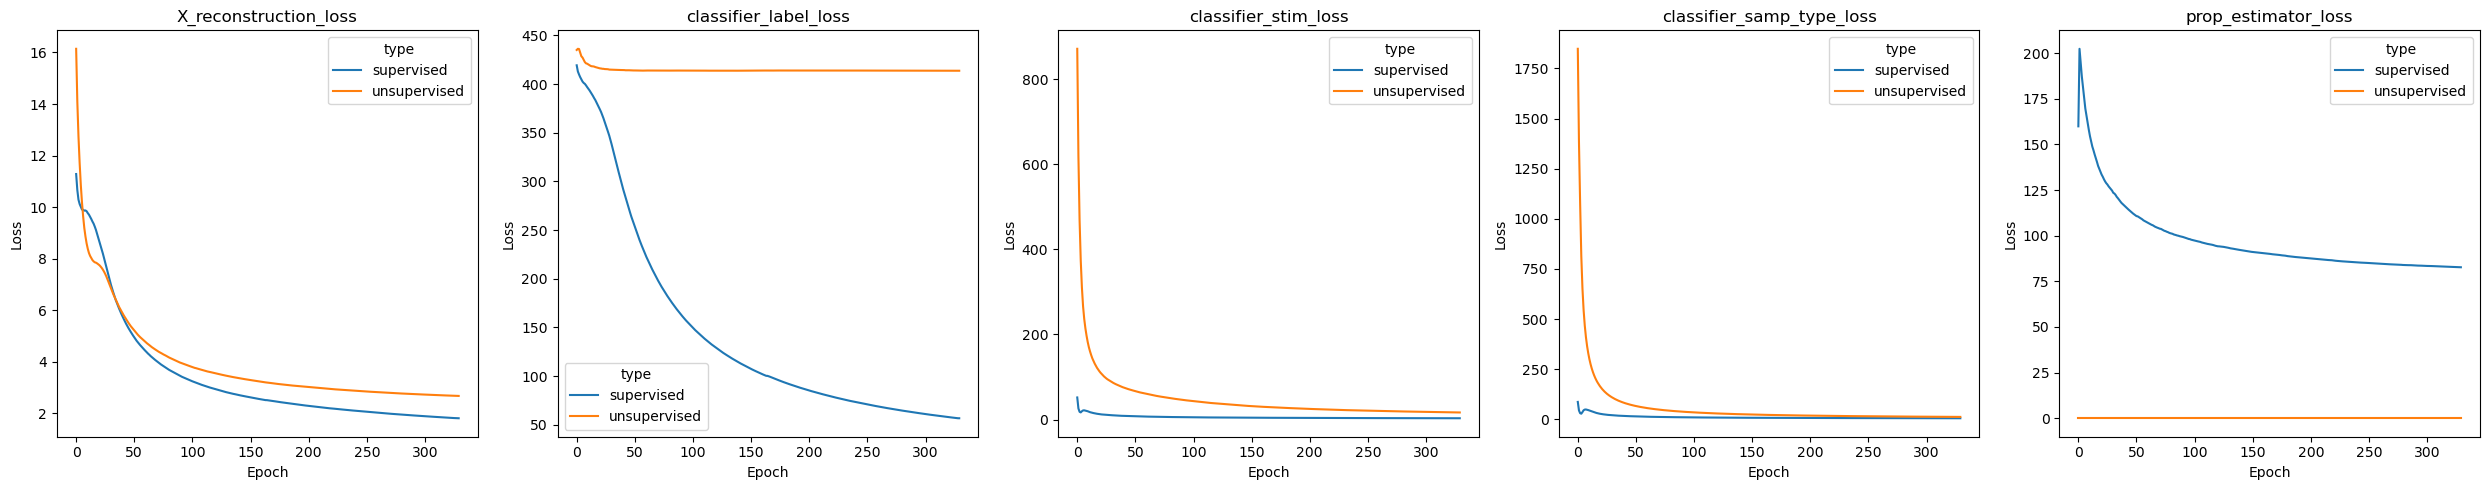

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/

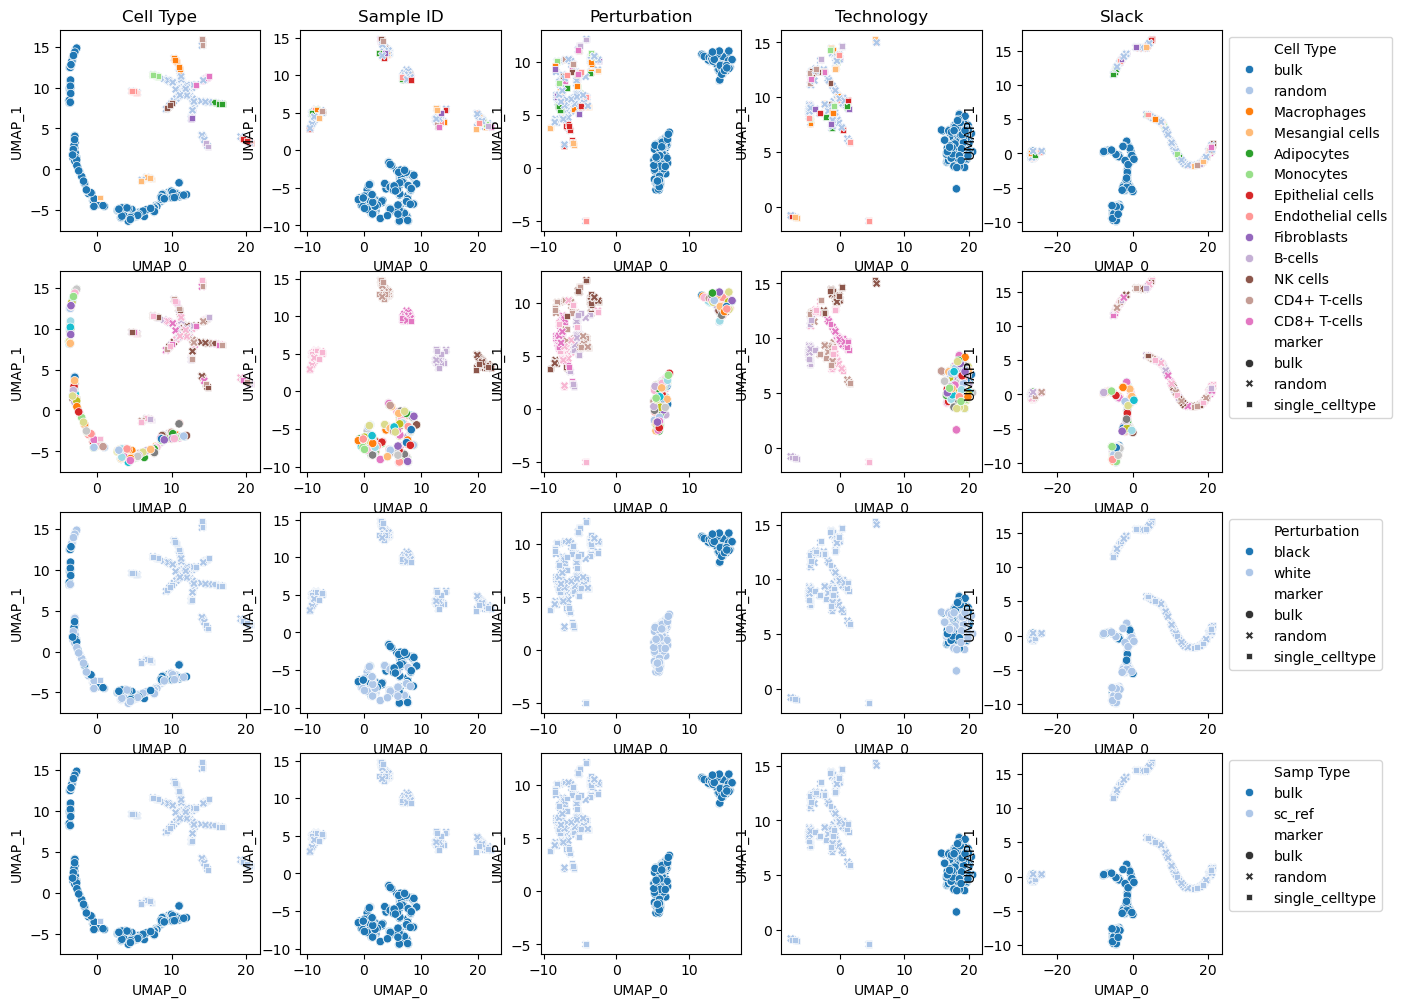

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


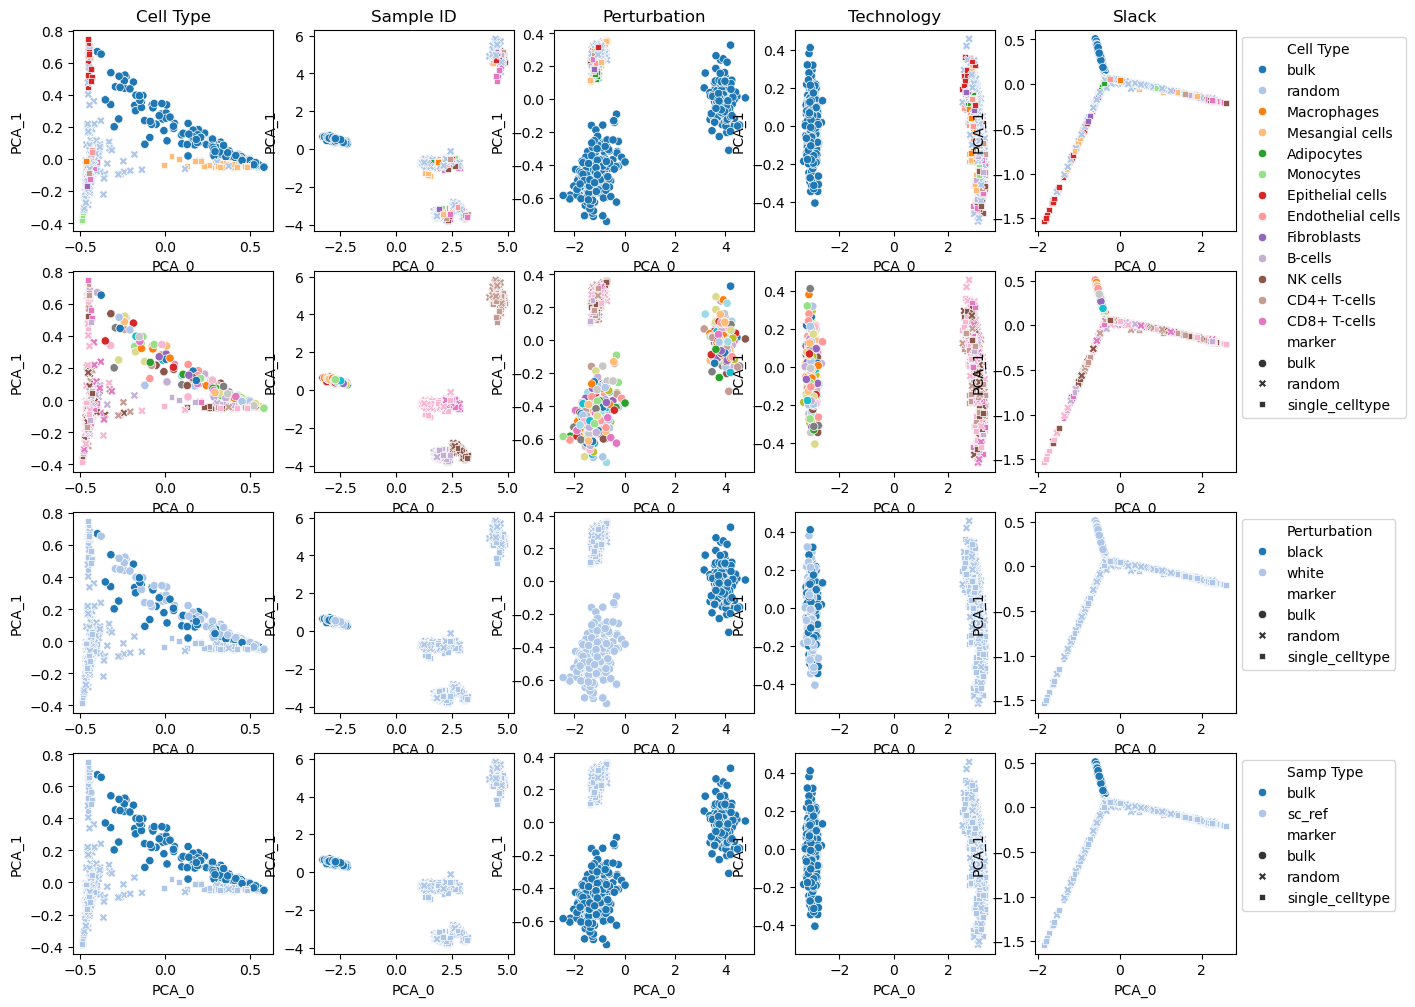

Epoch 2/2: 100%|██████████| 165/165 [00:56<00:00,  2.94it/s]


Training complete!


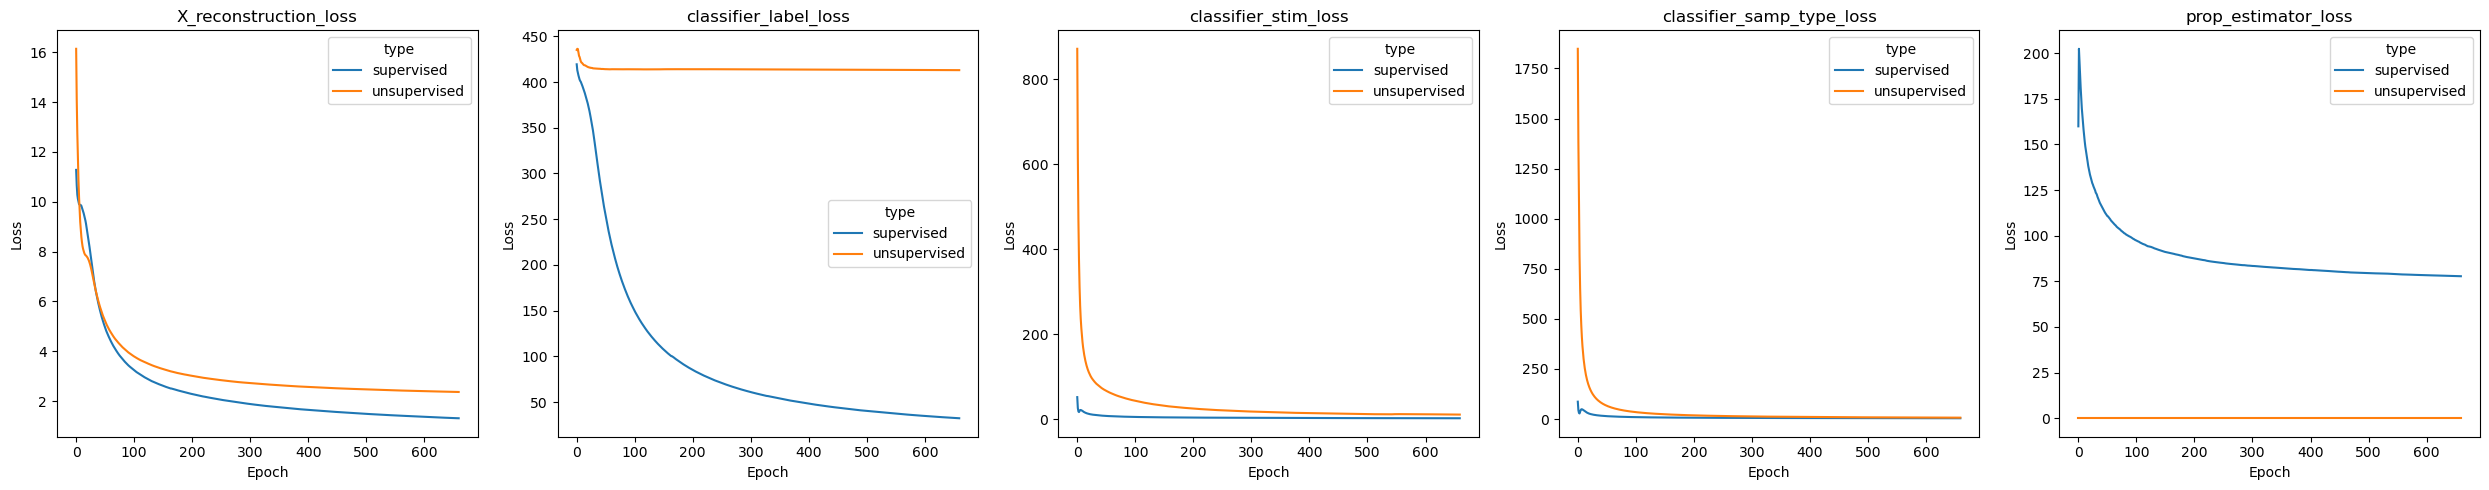

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/

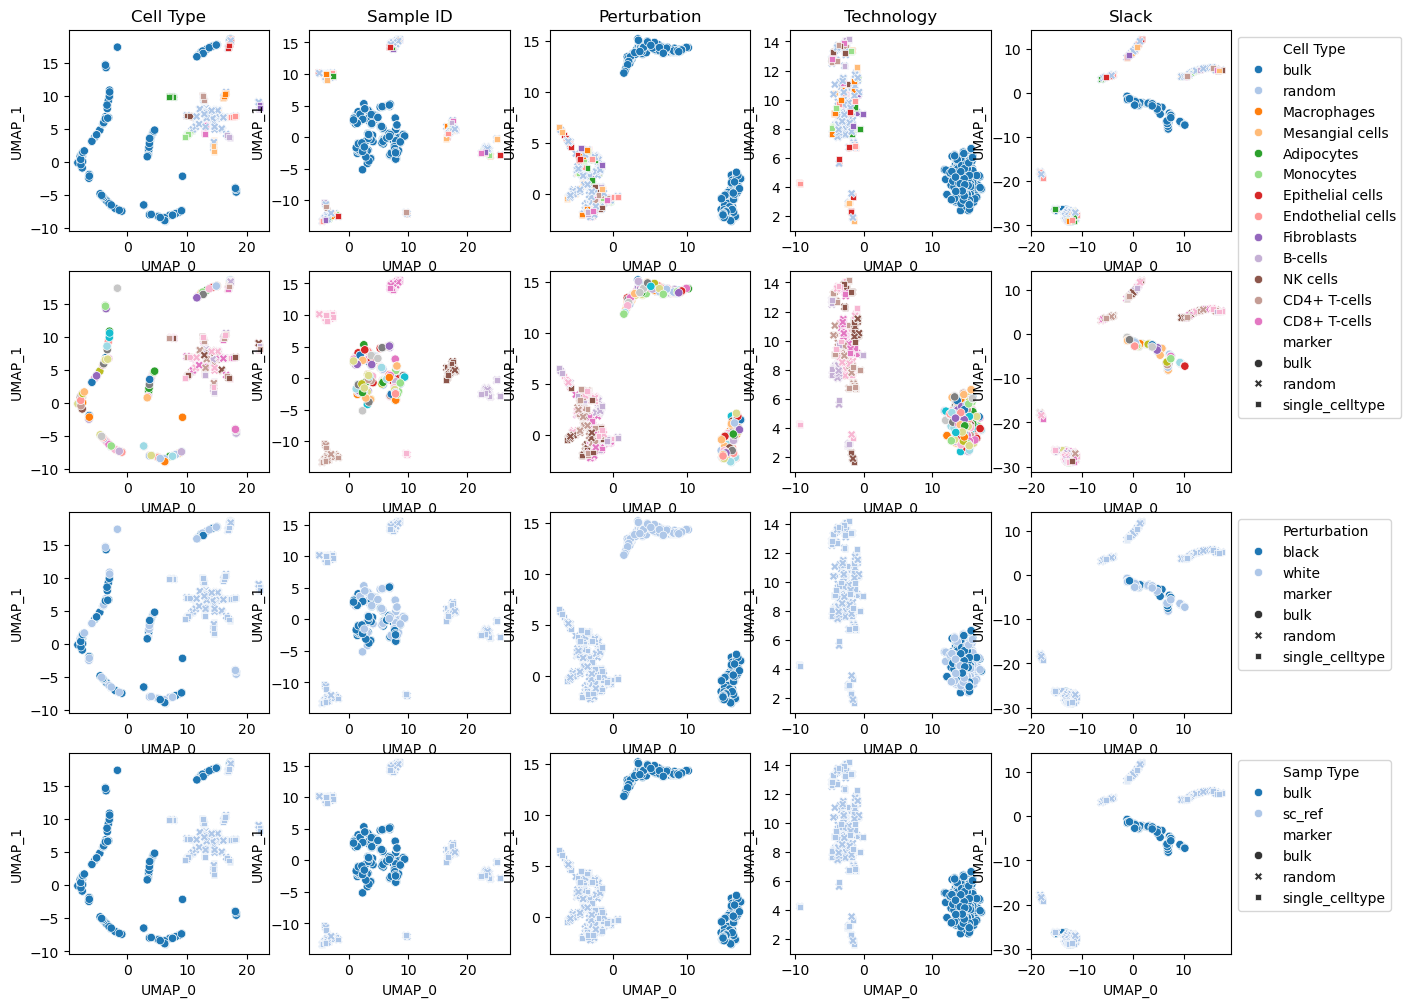

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


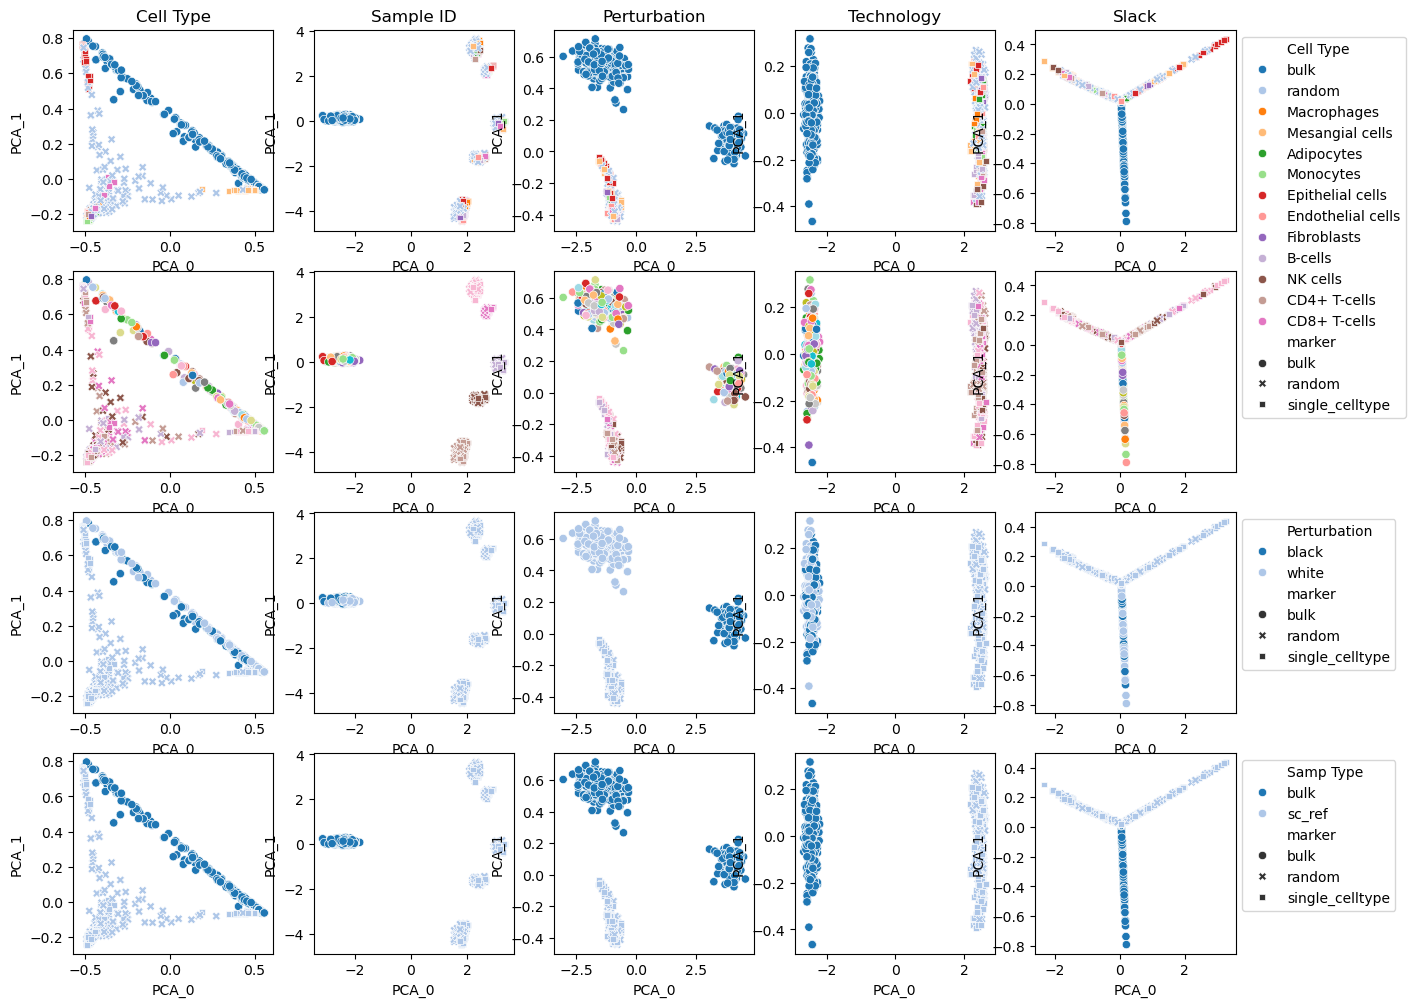

In [20]:
n_epochs_per_run = 2
loss_df_concat = pd.DataFrame()

for _i in range(2):

    all_loss_df = fit_buddi4_v2(
        supervised_buddi, unsupervised_buddi, 
        ds_sup, ds_unsup, 
        epochs=n_epochs_per_run, batch_size=64, prefetch=True
    )
    all_loss_df['epoch'] = all_loss_df['epoch'] + _i * n_epochs_per_run

    loss_df_concat = pd.concat([loss_df_concat, all_loss_df], ignore_index=True)
    loss_df_concat['index'] = loss_df_concat.groupby('type').cumcount()

    simple_plot_loss(loss_df_concat)

    plot_latent_spaces_buddi4(
        unsupervised_buddi,
        X_tmp,
        meta_tmp,
        type='UMAP',
        alpha=1,    
        panel_width=3,        
        palette="tab20"
    )

    plot_latent_spaces_buddi4(
        unsupervised_buddi,
        X_tmp,
        meta_tmp,
        type='PCA',
        alpha=1,    
        panel_width=3,
        palette="tab20"
    )